<h1><center> Chicago Car Crash Injury Classification </center></h1>

In [ ]:
import time, os
from datetime import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold,  GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import imblearn
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score

!pip install --quiet shap==0.39.0
import shap

# Warning suppression
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

## Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('drive/MyDrive/ALDAP/Traffic_Crashes_-_Crashes.csv')

In [ ]:
data.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,012c5bfce715efb2f2b387d6dd86f9c13e9dc1809fb52a...,JG341943,NaN,07/12/2023 03:05:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,2.0,0.0,15,4,7,41.778542,-87.742065,POINT (-87.742064741348 41.778541938106)
1,01d457f032e23d935a0b8f6b4c88221375180ffd4cd959...,JG338388,NaN,07/12/2023 05:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,17,4,7,41.742131,-87.721824,POINT (-87.72182410033 41.742130554062)
2,02249b4747a4bf40b88a8357304a98dfeaef9c38eebbf0...,JG350008,NaN,07/12/2023 02:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,...,0.0,0.0,1.0,0.0,14,4,7,41.719844,-87.584790,POINT (-87.584789974824 41.719844228292)
3,03e3b6caad71b78ed9ae325648effa9512bfb2517aed30...,JG338049,NaN,07/12/2023 07:05:00 AM,30,TRAFFIC SIGNAL,UNKNOWN,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,7,4,7,41.925105,-87.668291,POINT (-87.668291181568 41.925104953308)
4,0481fc919b38f1572d4ba04b069766102d904a662ff096...,JG338431,NaN,07/12/2023 06:30:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,18,4,7,41.975258,-87.751991,POINT (-87.751990557158 41.97525809527)


# Data Exploration

In [ ]:
print("Shape of the data: {}".format(data.shape))

Shape of the data: (746498, 49)


In [ ]:
data.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

In [ ]:
print("Total number of columns: {}".format(len(data.columns)))

Total number of columns: 49


In [ ]:
data.dtypes

CRASH_RECORD_ID                   object
RD_NO                             object
CRASH_DATE_EST_I                  object
CRASH_DATE                        object
POSTED_SPEED_LIMIT                 int64
TRAFFIC_CONTROL_DEVICE            object
DEVICE_CONDITION                  object
WEATHER_CONDITION                 object
LIGHTING_CONDITION                object
FIRST_CRASH_TYPE                  object
TRAFFICWAY_TYPE                   object
LANE_CNT                         float64
ALIGNMENT                         object
ROADWAY_SURFACE_COND              object
ROAD_DEFECT                       object
REPORT_TYPE                       object
CRASH_TYPE                        object
INTERSECTION_RELATED_I            object
NOT_RIGHT_OF_WAY_I                object
HIT_AND_RUN_I                     object
DAMAGE                            object
DATE_POLICE_NOTIFIED              object
PRIM_CONTRIBUTORY_CAUSE           object
SEC_CONTRIBUTORY_CAUSE            object
STREET_NO       

In [ ]:
print("Number of integer columns: {}".format(data.dtypes.tolist().count(data.dtypes[4])))
print("Number of object columns: {}".format(data.dtypes.tolist().count(data.dtypes[0])))

Number of integer columns: 6
Number of object columns: 32


In [ ]:
duplicate = data[data.duplicated() == True]
print("Number of duplicate rows: {}".format(len(duplicate)))

Number of duplicate rows: 0


In [ ]:
data.isna().sum()

CRASH_RECORD_ID                       0
RD_NO                              4307
CRASH_DATE_EST_I                 690109
CRASH_DATE                            0
POSTED_SPEED_LIMIT                    0
TRAFFIC_CONTROL_DEVICE                0
DEVICE_CONDITION                      0
WEATHER_CONDITION                     0
LIGHTING_CONDITION                    0
FIRST_CRASH_TYPE                      0
TRAFFICWAY_TYPE                       0
LANE_CNT                         547494
ALIGNMENT                             0
ROADWAY_SURFACE_COND                  0
ROAD_DEFECT                           0
REPORT_TYPE                       21222
CRASH_TYPE                            0
INTERSECTION_RELATED_I           575368
NOT_RIGHT_OF_WAY_I               711724
HIT_AND_RUN_I                    513706
DAMAGE                                0
DATE_POLICE_NOTIFIED                  0
PRIM_CONTRIBUTORY_CAUSE               0
SEC_CONTRIBUTORY_CAUSE                0
STREET_NO                             0


In [ ]:
print("Total number of missing values: {}".format(data.isna().sum().sum()))
print("Number of columns with missing values: {}".format(len(data.isnull().sum().tolist())-data.isnull().sum().tolist().count(0)))
print("Number of columns without missing values: {}".format(data.isnull().sum().tolist().count(0)))

Total number of missing values: 7533934
Number of columns with missing values: 27
Number of columns without missing values: 22


In [ ]:
# Summary of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746498 entries, 0 to 746497
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                746498 non-null  object 
 1   RD_NO                          742191 non-null  object 
 2   CRASH_DATE_EST_I               56389 non-null   object 
 3   CRASH_DATE                     746498 non-null  object 
 4   POSTED_SPEED_LIMIT             746498 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         746498 non-null  object 
 6   DEVICE_CONDITION               746498 non-null  object 
 7   WEATHER_CONDITION              746498 non-null  object 
 8   LIGHTING_CONDITION             746498 non-null  object 
 9   FIRST_CRASH_TYPE               746498 non-null  object 
 10  TRAFFICWAY_TYPE                746498 non-null  object 
 11  LANE_CNT                       199004 non-null  float64
 12  ALIGNMENT                     

In [ ]:
data.describe(include = "all").head(4).T

,count,unique,top,freq
CRASH_RECORD_ID,746498,746498,012c5bfce715efb2f2b387d6dd86f9c13e9dc1809fb52a...,1
RD_NO,742191,742191,JG341943,1
CRASH_DATE_EST_I,56389,2,Y,49160
CRASH_DATE,746498,488837,12/29/2020 05:00:00 PM,30
POSTED_SPEED_LIMIT,746498.0,NaN,NaN,NaN
TRAFFIC_CONTROL_DEVICE,746498,19,NO CONTROLS,426333
DEVICE_CONDITION,746498,8,NO CONTROLS,431347
WEATHER_CONDITION,746498,12,CLEAR,588571
LIGHTING_CONDITION,746498,6,DAYLIGHT,481127
FIRST_CRASH_TYPE,746498,18,PARKED MOTOR VEHICLE,174012


In [ ]:
df = data

In [ ]:
def create_bar_plot(format, title, col1, col2, xlab, ylab):
  fig, ax = plt.subplots()
  if (format == "horizontal"):
    bars = ax.barh(col1, col2)
    ax.bar_label(bars)
  else:
    bars = ax.bar(col1, col2)
    plt.xticks(range(len(col1)), col1)
  plt.title(title)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.show()

            Injury Severity   Count
0   NO INDICATION OF INJURY  643460
1  NONINCAPACITATING INJURY   57308
2     REPORTED, NOT EVIDENT   30560
3     INCAPACITATING INJURY   12728
4                     FATAL     812



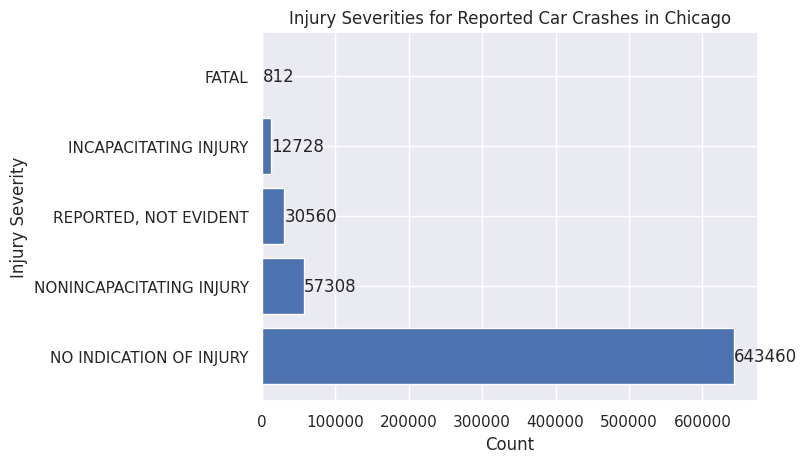

In [ ]:
### Exploratory Data Analysis

## Looking at our possible predictor variables

# Most Severe Injury
m_severe_v_counts = df.MOST_SEVERE_INJURY.value_counts()
most_severe_injury_counts = pd.DataFrame({"Injury Severity" : m_severe_v_counts.index, "Count" : m_severe_v_counts.values})

# Displaying the counts for each level of MOST_SEVERE_INJURY
print(most_severe_injury_counts)
print()

# Creating a horizontal bar plot to display this same information graphically
create_bar_plot("horizontal", "Injury Severities for Reported Car Crashes in Chicago",
                most_severe_injury_counts["Injury Severity"], most_severe_injury_counts["Count"], "Count",
                "Injury Severity")

In [ ]:
# Dropping rows na values
m_severe_sub_df = df[df["MOST_SEVERE_INJURY"].isna() == False]
m_severe_unique = m_severe_sub_df.MOST_SEVERE_INJURY.unique()

One-Way Frequency Table for all Injury Levels
    Speed Limit   Count  Percentage
8             5    4457    0.005984
5            10   17217    0.023114
4            15   26350    0.035375
3            20   31035    0.041665
2            25   46799    0.062829
0            30  548031    0.735742
1            35   50001    0.067127
6            40    7177    0.009635
7            45    4887    0.006561
10           50     195    0.000262
9            55     731    0.000981
11           60      45    0.000060
12           65      18    0.000024
13           70       4    0.000005



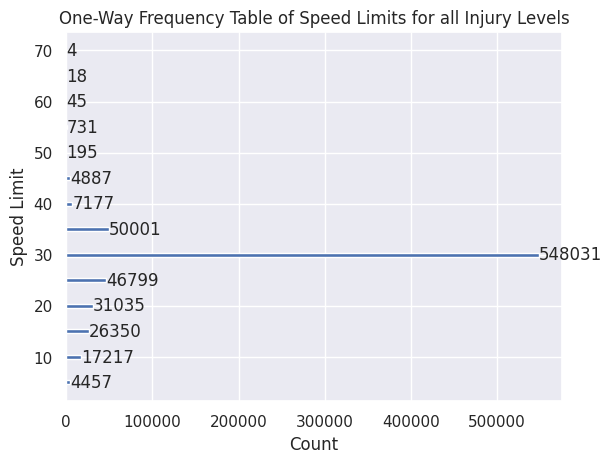

In [ ]:
inj = m_severe_sub_df[m_severe_sub_df["POSTED_SPEED_LIMIT"] >= 5]
inj = inj[inj["POSTED_SPEED_LIMIT"] <= 70]
inj = inj[inj["POSTED_SPEED_LIMIT"] % 5 == 0]

comp_speed_freqs = inj.POSTED_SPEED_LIMIT.value_counts()
comp_injury_speed_lim_freq = pd.DataFrame({"Speed Limit" : comp_speed_freqs.index, "Count" : comp_speed_freqs.values})

comp_injury_speed_lim_freq = comp_injury_speed_lim_freq.sort_values(by = "Speed Limit")

comp_injury_speed_lim_freq["Percentage"] = comp_injury_speed_lim_freq["Count"] / len(m_severe_sub_df)
print("One-Way Frequency Table for all Injury Levels")
print(comp_injury_speed_lim_freq)
print()

create_bar_plot("horizontal", "One-Way Frequency Table of Speed Limits for all Injury Levels",
                comp_injury_speed_lim_freq["Speed Limit"], comp_injury_speed_lim_freq["Count"], "Count",
                "Speed Limit")

One-Way Frequency Table for the NO INDICATION OF INJURY Injury Level
    Speed Limit   Count  Percentage
7             5    4240    0.006589
5            10   16489    0.025626
4            15   24707    0.038397
3            20   28400    0.044136
1            25   41738    0.064865
0            30  468869    0.728668
2            35   41100    0.063873
6            40    5730    0.008905
8            45    3981    0.006187
10           50     164    0.000255
9            55     619    0.000962
11           60      39    0.000061
12           65      15    0.000023
13           70       4    0.000006



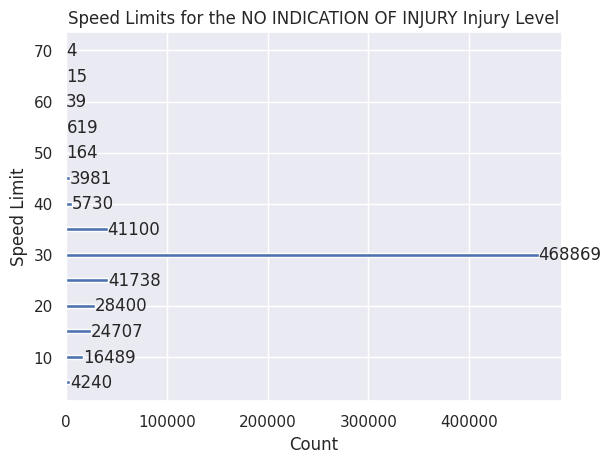

One-Way Frequency Table for the REPORTED, NOT EVIDENT Injury Level
    Speed Limit  Count  Percentage
8             5     69    0.002258
7            10    248    0.008115
4            15    484    0.015838
3            20    766    0.025065
2            25   1358    0.044437
0            30  24188    0.791492
1            35   2488    0.081414
5            40    420    0.013743
6            45    267    0.008737
10           50      8    0.000262
9            55     24    0.000785
11           60      3    0.000098



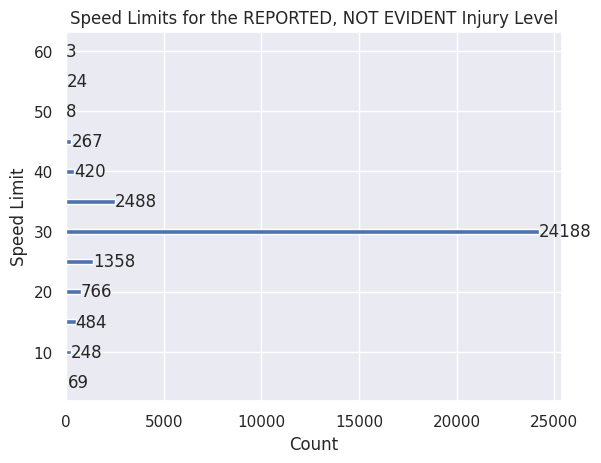

One-Way Frequency Table for the NONINCAPACITATING INJURY Injury Level
    Speed Limit  Count  Percentage
8             5    119    0.002076
7            10    391    0.006823
4            15    937    0.016350
3            20   1531    0.026715
2            25   2974    0.051895
0            30  44657    0.779245
1            35   5105    0.089080
5            40    777    0.013558
6            45    484    0.008446
10           50     17    0.000297
9            55     68    0.001187
11           60      2    0.000035
12           65      2    0.000035



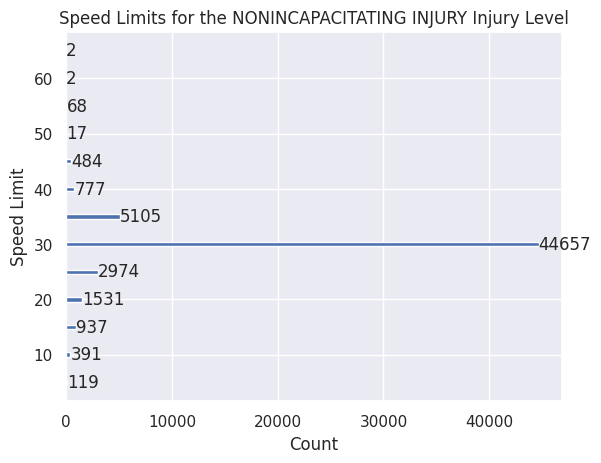

One-Way Frequency Table for the INCAPACITATING INJURY Injury Level
    Speed Limit  Count  Percentage
8             5     26    0.002043
7            10     83    0.006521
5            15    205    0.016106
3            20    324    0.025456
2            25    674    0.052954
0            30   9711    0.762964
1            35   1236    0.097109
4            40    232    0.018228
6            45    137    0.010764
10           50      6    0.000471
9            55     20    0.001571
11           60      1    0.000079
12           65      1    0.000079



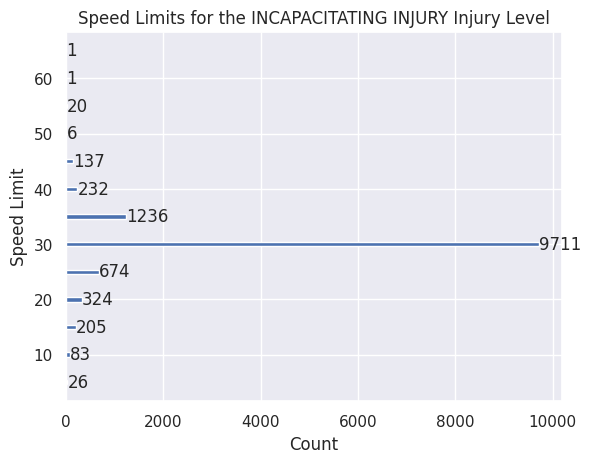

One-Way Frequency Table for the FATAL Injury Level
   Speed Limit  Count  Percentage
8            5      3    0.003695
7           10      6    0.007389
5           15     17    0.020936
6           20     14    0.017241
2           25     55    0.067734
0           30    606    0.746305
1           35     72    0.088670
3           40     18    0.022167
4           45     18    0.022167



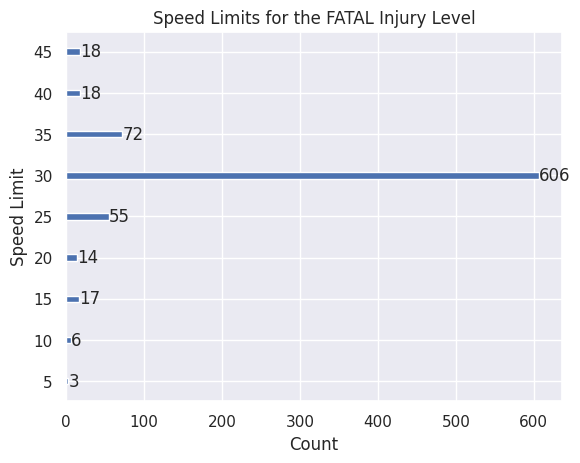

In [ ]:
# Loops through the severity levels
for severity_level in m_severe_unique:
  # Subsets according the current injury level
  injury_severity = m_severe_sub_df[m_severe_sub_df["MOST_SEVERE_INJURY"] == severity_level]

  # Subsets the speed limits to only include valid speed limits
  injuries = injury_severity[injury_severity["POSTED_SPEED_LIMIT"] >= 5]
  injuries = injuries[injuries["POSTED_SPEED_LIMIT"] <= 70]
  injuries = injuries[injuries["POSTED_SPEED_LIMIT"] % 5 == 0]

  # Finds the frequencies of the speed limits and severity levels and then converts the series into a data frame
  speed_freqs = injuries.POSTED_SPEED_LIMIT.value_counts()
  injury_speed_lim_freq = pd.DataFrame({"Speed Limit" : speed_freqs.index, "Count" : speed_freqs.values})

  # Sorts the data frame by speed limit so that the display is cleaner when plotting the data
  injury_speed_lim_freq = injury_speed_lim_freq.sort_values(by = "Speed Limit")

  # Finishes the set up for the one-way frequencies
  injury_speed_lim_freq["Percentage"] = injury_speed_lim_freq["Count"] / len(injury_severity)
  print("One-Way Frequency Table for the " + severity_level + " Injury Level")
  print(injury_speed_lim_freq)
  print()

  # Plots the frequencies
  title = "Speed Limits for the " + severity_level + " Injury Level"
  create_bar_plot("horizontal", title,
                injury_speed_lim_freq["Speed Limit"], injury_speed_lim_freq["Count"], "Count",
                "Speed Limit")

One-Way Frequency Table for all Injury Levels
                      Crash Type   Count  Percentage
0           PARKED MOTOR VEHICLE  170332    0.228674
1                       REAR END  167394    0.224730
2       SIDESWIPE SAME DIRECTION  112550    0.151101
3                        TURNING  105276    0.141335
4                          ANGLE   79938    0.107318
5                   FIXED OBJECT   34306    0.046056
6                     PEDESTRIAN   16987    0.022805
7                   PEDALCYCLIST   10985    0.014748
8   SIDESWIPE OPPOSITE DIRECTION   10449    0.014028
9                   OTHER OBJECT    7082    0.009508
10                 REAR TO FRONT    6711    0.009010
11                       HEAD ON    6304    0.008463
12                  REAR TO SIDE    3947    0.005299
13            OTHER NONCOLLISION    2272    0.003050
14                  REAR TO REAR    1406    0.001888
15                        ANIMAL     524    0.000703
16                    OVERTURNED     446    0.000599


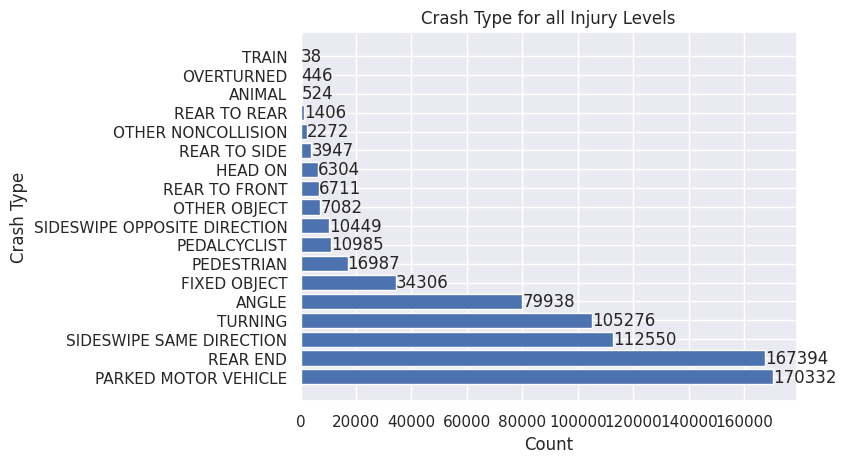

In [ ]:
comp_crash_type_freqs = inj.FIRST_CRASH_TYPE.value_counts()
comp_injury_crash_type_freq = pd.DataFrame({"Crash Type" : comp_crash_type_freqs.index,
                                           "Count" : comp_crash_type_freqs.values})

comp_injury_crash_type_freq["Percentage"] = comp_injury_crash_type_freq["Count"] / len(m_severe_sub_df)
print("One-Way Frequency Table for all Injury Levels")
print(comp_injury_crash_type_freq)
print()

title = "Crash Type for all Injury Levels"
create_bar_plot("horizontal", title,
                comp_injury_crash_type_freq["Crash Type"], comp_injury_crash_type_freq["Count"], "Count",
                "Crash Type")

One-Way Frequency Table for the NO INDICATION OF INJURY Injury Level
                      Crash Type   Count  Percentage
0           PARKED MOTOR VEHICLE  167252    0.259926
1                       REAR END  147041    0.228516
2       SIDESWIPE SAME DIRECTION  107827    0.167574
3                        TURNING   89255    0.138711
4                          ANGLE   63263    0.098317
5                   FIXED OBJECT   28760    0.044696
6   SIDESWIPE OPPOSITE DIRECTION    9491    0.014750
7                  REAR TO FRONT    6455    0.010032
8                   OTHER OBJECT    6338    0.009850
9                        HEAD ON    4474    0.006953
10                  REAR TO SIDE    3715    0.005773
11                  PEDALCYCLIST    3339    0.005189
12                    PEDESTRIAN    2167    0.003368
13            OTHER NONCOLLISION    1924    0.002990
14                  REAR TO REAR    1398    0.002173
15                        ANIMAL     491    0.000763
16                    OVERTURN

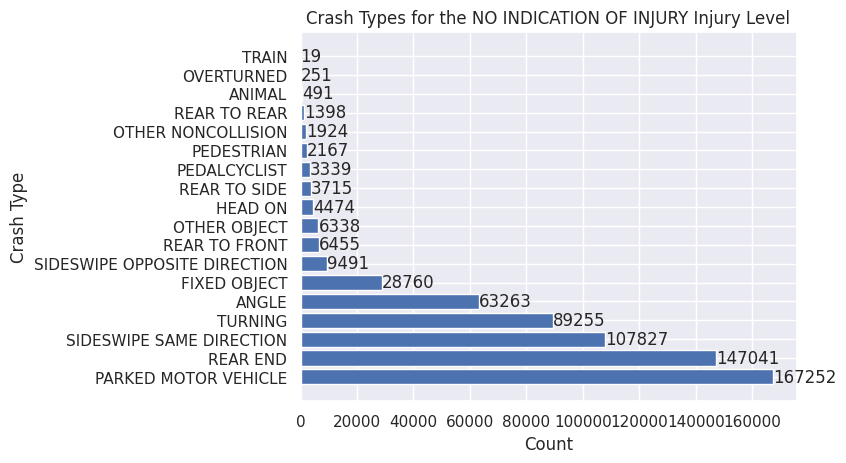

One-Way Frequency Table for the REPORTED, NOT EVIDENT Injury Level
                      Crash Type  Count  Percentage
0                       REAR END  10185    0.333279
1                        TURNING   5341    0.174771
2                          ANGLE   5307    0.173658
3                     PEDESTRIAN   2680    0.087696
4       SIDESWIPE SAME DIRECTION   2253    0.073724
5           PARKED MOTOR VEHICLE   1412    0.046204
6                   PEDALCYCLIST   1268    0.041492
7                   FIXED OBJECT    988    0.032330
8                        HEAD ON    348    0.011387
9   SIDESWIPE OPPOSITE DIRECTION    338    0.011060
10                  OTHER OBJECT    152    0.004974
11                 REAR TO FRONT    110    0.003599
12                  REAR TO SIDE     79    0.002585
13            OTHER NONCOLLISION     56    0.001832
14                    OVERTURNED     22    0.000720
15                  REAR TO REAR     10    0.000327
16                        ANIMAL      6    0.0001

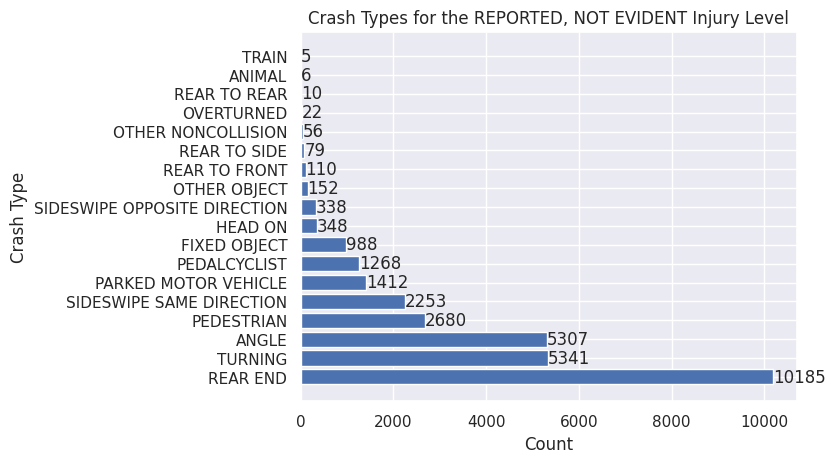

One-Way Frequency Table for the NONINCAPACITATING INJURY Injury Level
                      Crash Type  Count  Percentage
0                          ANGLE  10090    0.176066
1                       REAR END   9938    0.173414
2                        TURNING   9531    0.166312
3                     PEDESTRIAN   9117    0.159088
4                   PEDALCYCLIST   5368    0.093669
5                   FIXED OBJECT   3739    0.065244
6           PARKED MOTOR VEHICLE   3622    0.063202
7       SIDESWIPE SAME DIRECTION   2860    0.049906
8                        HEAD ON   1177    0.020538
9   SIDESWIPE OPPOSITE DIRECTION    627    0.010941
10                  OTHER OBJECT    521    0.009091
11            OTHER NONCOLLISION    240    0.004188
12                 REAR TO FRONT    159    0.002774
13                  REAR TO SIDE    150    0.002617
14                    OVERTURNED    133    0.002321
15                        ANIMAL     14    0.000244
16                  REAR TO REAR     11    0.0

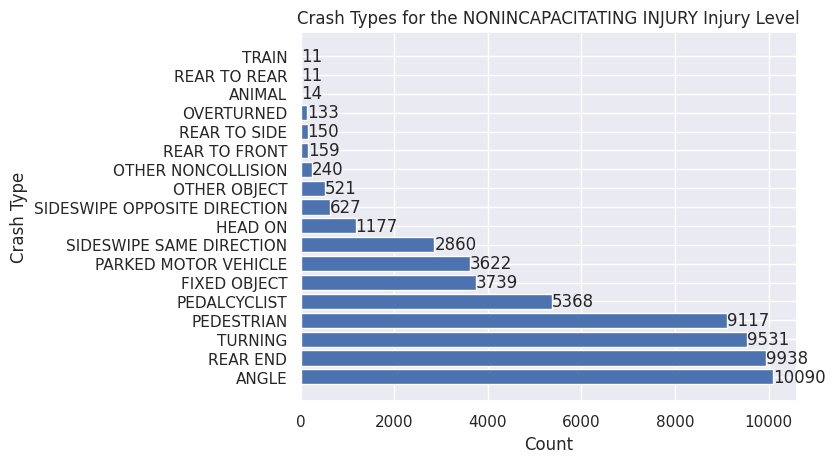

One-Way Frequency Table for the INCAPACITATING INJURY Injury Level
                      Crash Type  Count  Percentage
0                     PEDESTRIAN   2951    0.231851
1                          ANGLE   2010    0.157920
2                        TURNING   1762    0.138435
3                       REAR END   1594    0.125236
4                   FIXED OBJECT   1108    0.087052
5                   PEDALCYCLIST   1052    0.082652
6           PARKED MOTOR VEHICLE    868    0.068196
7       SIDESWIPE SAME DIRECTION    565    0.044390
8                        HEAD ON    333    0.026163
9                   OTHER OBJECT    173    0.013592
10  SIDESWIPE OPPOSITE DIRECTION    130    0.010214
11            OTHER NONCOLLISION     66    0.005185
12                    OVERTURNED     38    0.002986
13                  REAR TO SIDE     37    0.002907
14                 REAR TO FRONT     26    0.002043
15                        ANIMAL     11    0.000864
16                         TRAIN      2    0.0001

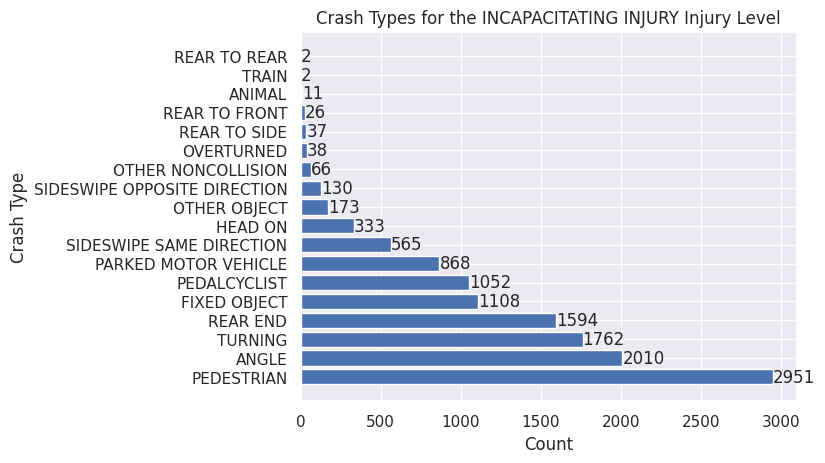

One-Way Frequency Table for the FATAL Injury Level
                      Crash Type  Count  Percentage
0                     PEDESTRIAN    204    0.251232
1                   FIXED OBJECT    202    0.248768
2           PARKED MOTOR VEHICLE     90    0.110837
3                          ANGLE     88    0.108374
4                        TURNING     62    0.076355
5                        HEAD ON     39    0.048030
6                       REAR END     36    0.044335
7                   PEDALCYCLIST     32    0.039409
8       SIDESWIPE SAME DIRECTION     21    0.025862
9                   OTHER OBJECT     16    0.019704
10  SIDESWIPE OPPOSITE DIRECTION      6    0.007389
11                        ANIMAL      5    0.006158
12                    OVERTURNED      4    0.004926
13            OTHER NONCOLLISION      4    0.004926
14                 REAR TO FRONT      2    0.002463
15                         TRAIN      1    0.001232



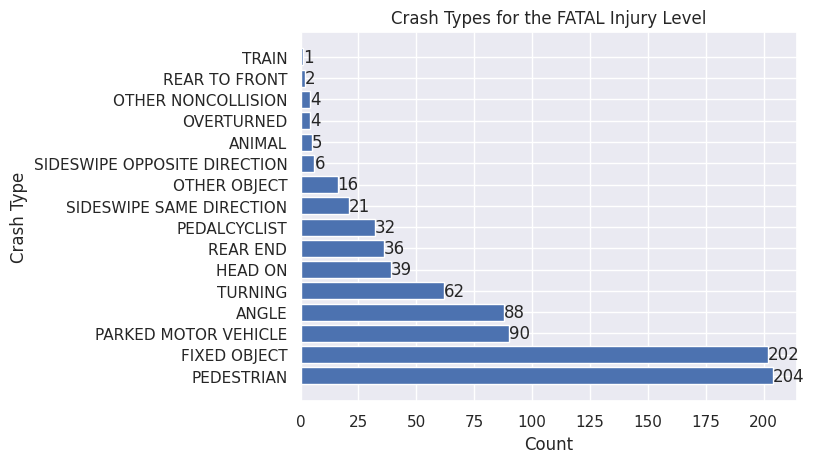

In [ ]:
# Loops through the severity levels
for severity_level in m_severe_unique:
  # Subsets according the current injury level
  injury_severity = m_severe_sub_df[m_severe_sub_df["MOST_SEVERE_INJURY"] == severity_level]

  crash_type_freqs = injury_severity.FIRST_CRASH_TYPE.value_counts()
  injury_crash_type_freq = pd.DataFrame({"Crash Type" : crash_type_freqs.index, "Count" : crash_type_freqs.values})

  injury_crash_type_freq["Percentage"] = injury_crash_type_freq["Count"] / len(injury_severity)
  print("One-Way Frequency Table for the " + severity_level + " Injury Level")
  print(injury_crash_type_freq)
  print()

  title = "Crash Types for the " + severity_level + " Injury Level"

  create_bar_plot("horizontal", title,
                  injury_crash_type_freq["Crash Type"], injury_crash_type_freq["Count"], "Count",
                  "Crash Type")

In [ ]:
three_way_sv_sl_ct_table_frame = m_severe_sub_df[["MOST_SEVERE_INJURY", "POSTED_SPEED_LIMIT", "FIRST_CRASH_TYPE"]]
three_way_sv_sl_ct_table_frame = three_way_sv_sl_ct_table_frame[three_way_sv_sl_ct_table_frame["POSTED_SPEED_LIMIT"] >= 5]
three_way_sv_sl_ct_table_frame = three_way_sv_sl_ct_table_frame[three_way_sv_sl_ct_table_frame["POSTED_SPEED_LIMIT"] <= 70]
three_way_sv_sl_ct_table_frame = three_way_sv_sl_ct_table_frame[three_way_sv_sl_ct_table_frame["POSTED_SPEED_LIMIT"] % 5 == 0]

severity_speed_limit_crash_type_crosstab = pd.crosstab(index = [three_way_sv_sl_ct_table_frame['MOST_SEVERE_INJURY'],
                                                                three_way_sv_sl_ct_table_frame['POSTED_SPEED_LIMIT']],
                                                       columns = three_way_sv_sl_ct_table_frame["FIRST_CRASH_TYPE"])
severity_speed_limit_crash_type_crosstab

FIRST_CRASH_TYPE                          ANGLE  ANIMAL  FIXED OBJECT  \
MOST_SEVERE_INJURY    POSTED_SPEED_LIMIT                                
FATAL                 5                       0       0             2   
                      10                      0       0             2   
                      15                      0       0             7   
                      20                      1       0             4   
                      25                      3       1            13   
...                                         ...     ...           ...   
REPORTED, NOT EVIDENT 40                     16       0            54   
                      45                      7       0            23   
                      50                      0       0             0   
                      55                      1       0             2   
                      60                      0       0             1   

FIRST_CRASH_TYPE                          HEAD ON  OTHER NONCOLLISION  \
MOST_SEVERE_INJURY    POSTED_SPEED_LIMIT                                
FATAL                 5                         0                   0   
                      10                        0                   0   
                      15                        0                   0   
                      20                        0                   0   
                      25                        1                   0   
...                                           ...                 ...   
REPORTED, NOT EVIDENT 40                        2                   0   
                      45                        0                   7   
                      50                        0                   0   
                      55                        0                   0   
                      60                        0                   0   

FIRST_CRASH_TYPE                          OTHER OBJECT  OVERTURNED  \
MOST_SEVERE_INJURY    POSTED_SPEED_LIMIT                             
FATAL                 5                              0           0   
                      10                             0           0   
                      15                             0           0   
                      20                             0           0   
                      25                             1           0   
...                                                ...         ...   
REPORTED, NOT EVIDENT 40                             6           0   
                      45                             4           0   
                      50                             1           0   
                      55                             1           0   
                      60                             0           0   

FIRST_CRASH_TYPE                          PARKED MOTOR VEHICLE  PEDALCYCLIST  \
MOST_SEVERE_INJURY    POSTED_SPEED_LIMIT                                       
FATAL                 5                                      0             0   
                      10                                     1             0   
                      15                                     5             0   
                      20                                     3             0   
                      25                                    15             4   
...                                                        ...           ...   
REPORTED, NOT EVIDENT 40                                     1             2   
                      45                                     2             0   
                      50                                     1             0   
                      55                                     0             0   
                      60                                     0             0   

FIRST_CRASH_TYPE                          PEDESTRIAN  REAR END  REAR TO FRONT  \
MOST_SEVERE_INJURY    POSTED_SPEED_LIMIT                           

One-Way Frequency Table for all Injury Levels
    Hour  Count  Percentage
18     0  15927    0.021382
19     1  13592    0.018248
20     2  11673    0.015671
22     3   9489    0.012739
23     4   8490    0.011398
21     5  10066    0.013514
17     6  15930    0.021386
12     7  30804    0.041355
7      8  38547    0.051750
9      9  33647    0.045172
11    10  33378    0.044811
8     11  37345    0.050136
6     12  43345    0.058192
5     13  45028    0.060451
3     14  49637    0.066639
0     15  56796    0.076250
1     16  56490    0.075839
2     17  55139    0.074025
4     18  45503    0.061089
10    19  33474    0.044940
13    20  26943    0.036172
14    21  24237    0.032539
15    22  22239    0.029856
16    23  19228    0.025814



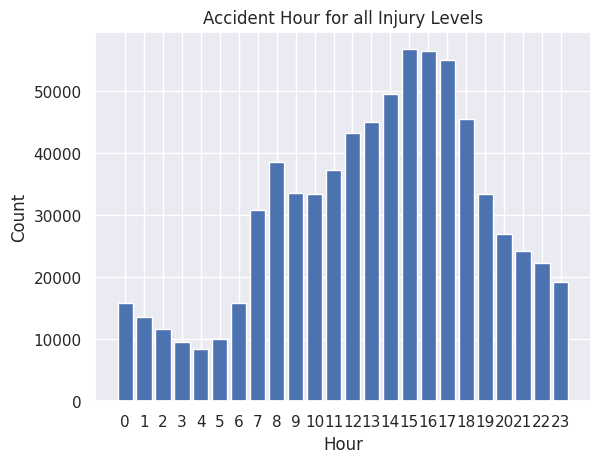

In [ ]:
comp_hour_freqs = inj.CRASH_HOUR.value_counts()
comp_injury_hour_freq = pd.DataFrame({"Hour" : comp_hour_freqs.index,
                                           "Count" : comp_hour_freqs.values})

comp_injury_hour_freq = comp_injury_hour_freq.sort_values(by = "Hour")

comp_injury_hour_freq["Percentage"] = comp_injury_hour_freq["Count"] / len(m_severe_sub_df)
print("One-Way Frequency Table for all Injury Levels")
print(comp_injury_hour_freq)
print()

title = "Accident Hour for all Injury Levels"
create_bar_plot("vertical", title,
                comp_injury_hour_freq["Hour"], comp_injury_hour_freq["Count"], "Hour",
                "Count")

One-Way Frequency Table for the NO INDICATION OF INJURY Injury Level
    Hour  Count  Percentage
18     0  13333    0.020721
19     1  11415    0.017740
20     2   9731    0.015123
22     3   7933    0.012329
23     4   7121    0.011067
21     5   8622    0.013399
17     6  13835    0.021501
12     7  27152    0.042197
7      8  34238    0.053209
9      9  29970    0.046576
10    10  29799    0.046311
8     11  33235    0.051650
6     12  38775    0.060260
4     13  39877    0.061973
3     14  43785    0.068046
0     15  50128    0.077904
1     16  49696    0.077232
2     17  48226    0.074948
5     18  39528    0.061430
11    19  28719    0.044632
13    20  22934    0.035642
14    21  20451    0.031783
15    22  18794    0.029208
16    23  16163    0.025119



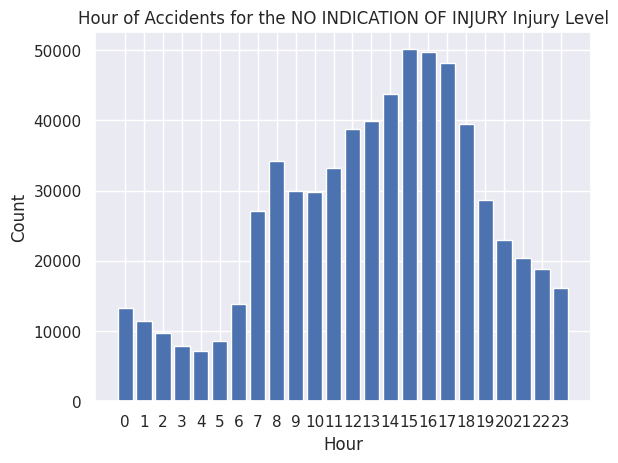

One-Way Frequency Table for the REPORTED, NOT EVIDENT Injury Level
    Hour  Count  Percentage
18     0    628    0.020550
19     1    529    0.017310
20     2    430    0.014071
22     3    336    0.010995
23     4    310    0.010144
21     5    372    0.012173
17     6    660    0.021597
11     7   1342    0.043914
7      8   1625    0.053174
12     9   1342    0.043914
10    10   1366    0.044699
8     11   1530    0.050065
6     12   1722    0.056348
5     13   1877    0.061420
3     14   2021    0.066132
1     15   2383    0.077978
2     16   2341    0.076603
0     17   2391    0.078240
4     18   1995    0.065281
9     19   1475    0.048266
13    20   1144    0.037435
14    21   1052    0.034424
15    22    935    0.030596
16    23    754    0.024673



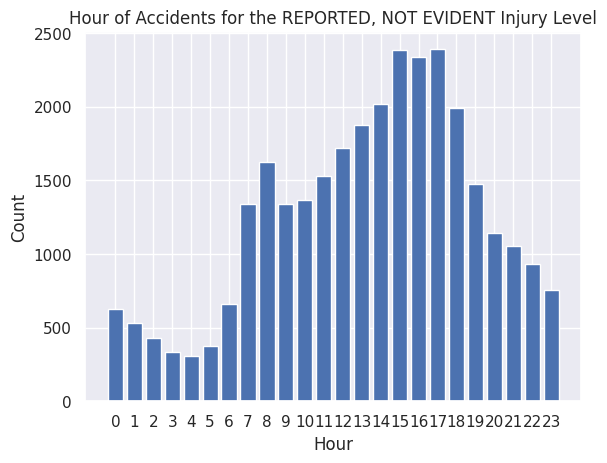

One-Way Frequency Table for the NONINCAPACITATING INJURY Injury Level
    Hour  Count  Percentage
17     0   1658    0.028931
18     1   1314    0.022929
20     2   1244    0.021707
21     3    993    0.017327
23     4    876    0.015286
22     5    924    0.016123
19     6   1308    0.022824
14     7   2226    0.038843
8      8   2627    0.045840
11     9   2367    0.041303
13    10   2260    0.039436
9     11   2578    0.044985
7     12   2762    0.048196
5     13   3102    0.054129
4     14   3557    0.062068
2     15   4028    0.070287
0     16   4139    0.072224
1     17   4104    0.071613
3     18   3582    0.062504
6     19   2869    0.050063
10    20   2486    0.043380
12    21   2308    0.040274
15    22   2092    0.036505
16    23   1904    0.033224



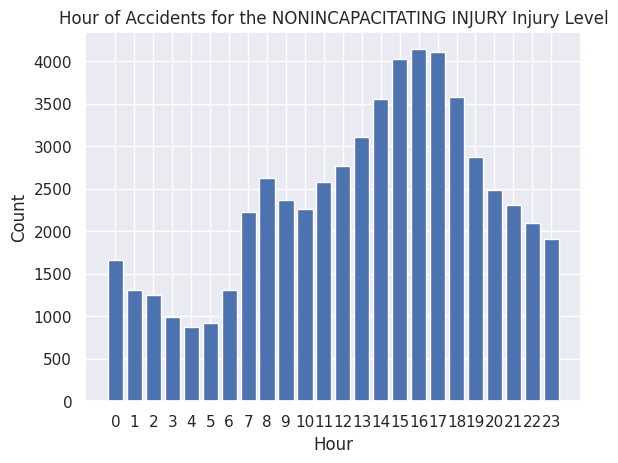

One-Way Frequency Table for the INCAPACITATING INJURY Injury Level
    Hour  Count  Percentage
17     0    388    0.030484
18     1    369    0.028991
20     2    310    0.024356
21     3    248    0.019485
23     4    233    0.018306
22     5    240    0.018856
19     6    333    0.026163
16     7    461    0.036219
10     8    572    0.044940
13     9    501    0.039362
15    10    473    0.037162
8     11    584    0.045883
7     12    626    0.049183
5     13    655    0.051461
4     14    748    0.058768
3     15    766    0.060182
1     16    808    0.063482
0     17    831    0.065289
2     18    777    0.061047
6     19    653    0.051304
9     20    581    0.045647
11    21    558    0.043840
12    22    522    0.041012
14    23    491    0.038576



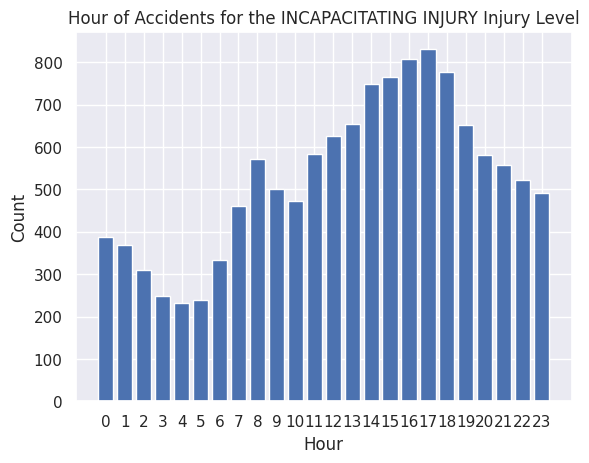

One-Way Frequency Table for the FATAL Injury Level
    Hour  Count  Percentage
9      0     35    0.043103
0      1     56    0.068966
4      2     49    0.060345
7      3     43    0.052956
10     4     34    0.041872
16     5     24    0.029557
22     6     17    0.020936
23     7     14    0.017241
19     8     21    0.025862
21     9     19    0.023399
20    10     20    0.024631
15    11     25    0.030788
8     12     40    0.049261
17    13     22    0.027094
12    14     30    0.036946
11    15     33    0.040640
18    16     22    0.027094
14    17     28    0.034483
13    18     30    0.036946
2     19     52    0.064039
6     20     45    0.055419
3     21     51    0.062808
5     22     49    0.060345
1     23     53    0.065271



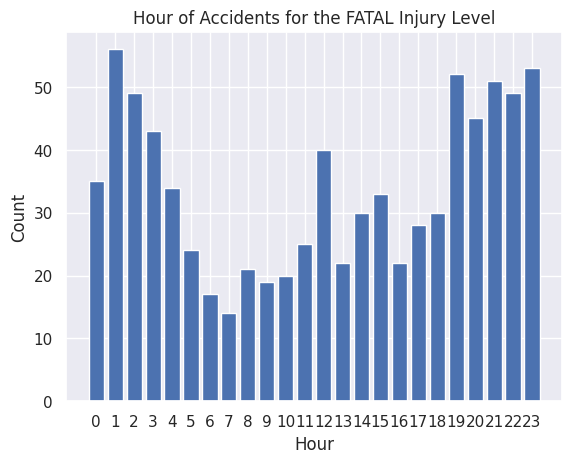

In [ ]:
for severity_level in m_severe_unique:

  injury_severity = m_severe_sub_df[m_severe_sub_df["MOST_SEVERE_INJURY"] == severity_level]

  hour_freqs = injury_severity.CRASH_HOUR.value_counts()
  injury_hour_freq = pd.DataFrame({"Hour" : hour_freqs.index, "Count" : hour_freqs.values})

  injury_hour_freq = injury_hour_freq.sort_values(by = "Hour")

  injury_hour_freq["Percentage"] = injury_hour_freq["Count"] / len(injury_severity)
  print("One-Way Frequency Table for the " + severity_level + " Injury Level")
  print(injury_hour_freq)
  print()

  title = "Hour of Accidents for the " + severity_level + " Injury Level"
  create_bar_plot("vertical", title,
                  injury_hour_freq["Hour"], injury_hour_freq["Count"], "Hour",
                  "Count")

One-Way Frequency Table for the NO INDICATION OF INJURY Injury Level
           Weather Condition   Count  Percentage
0                      CLEAR  505992    0.786361
1                       RAIN   53284    0.082809
2                    UNKNOWN   37202    0.057816
3                       SNOW   23286    0.036189
4            CLOUDY/OVERCAST   18563    0.028849
5                      OTHER    1907    0.002964
6      FREEZING RAIN/DRIZZLE    1112    0.001728
7             FOG/SMOKE/HAZE     904    0.001405
8                 SLEET/HAIL     773    0.001201
9               BLOWING SNOW     324    0.000504
10    SEVERE CROSS WIND GATE     108    0.000168
11  BLOWING SAND, SOIL, DIRT       5    0.000008



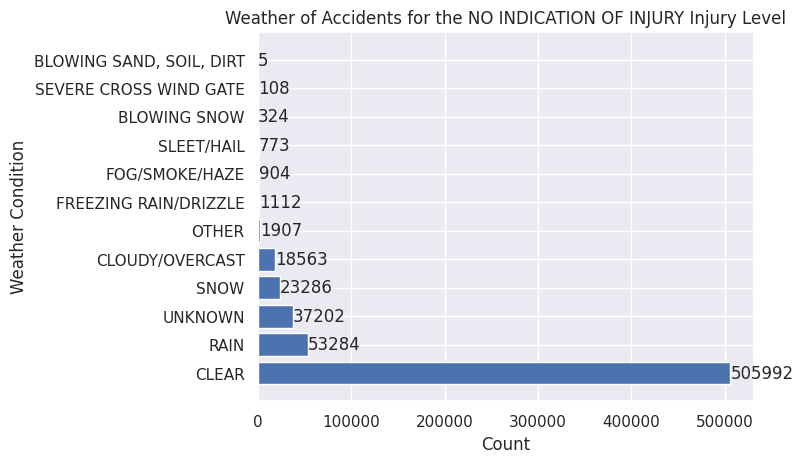

One-Way Frequency Table for the REPORTED, NOT EVIDENT Injury Level
         Weather Condition  Count  Percentage
0                    CLEAR  24064    0.787435
1                     RAIN   3248    0.106283
2          CLOUDY/OVERCAST   1139    0.037271
3                     SNOW   1062    0.034751
4                  UNKNOWN    706    0.023102
5                    OTHER    133    0.004352
6    FREEZING RAIN/DRIZZLE     74    0.002421
7           FOG/SMOKE/HAZE     61    0.001996
8               SLEET/HAIL     51    0.001669
9             BLOWING SNOW     18    0.000589
10  SEVERE CROSS WIND GATE      4    0.000131



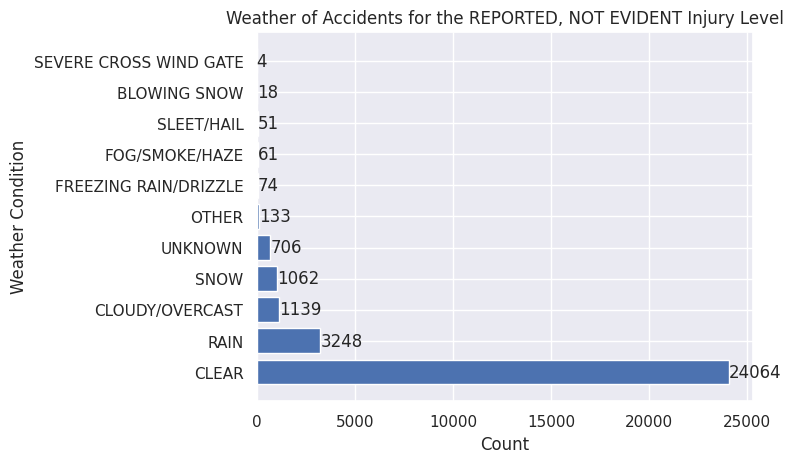

One-Way Frequency Table for the NONINCAPACITATING INJURY Injury Level
           Weather Condition  Count  Percentage
0                      CLEAR  46241    0.806886
1                       RAIN   5984    0.104418
2            CLOUDY/OVERCAST   1840    0.032107
3                       SNOW   1699    0.029647
4                    UNKNOWN    923    0.016106
5                      OTHER    222    0.003874
6      FREEZING RAIN/DRIZZLE    145    0.002530
7             FOG/SMOKE/HAZE    112    0.001954
8                 SLEET/HAIL     91    0.001588
9               BLOWING SNOW     38    0.000663
10    SEVERE CROSS WIND GATE     12    0.000209
11  BLOWING SAND, SOIL, DIRT      1    0.000017



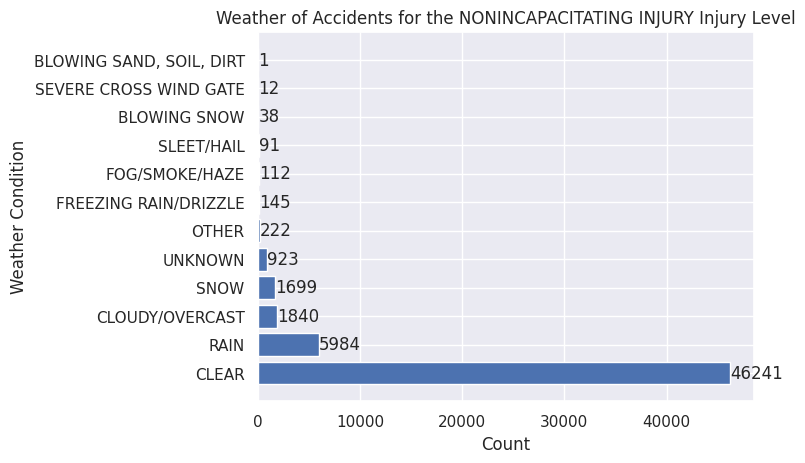

One-Way Frequency Table for the INCAPACITATING INJURY Injury Level
         Weather Condition  Count  Percentage
0                    CLEAR  10433    0.819689
1                     RAIN   1268    0.099623
2          CLOUDY/OVERCAST    391    0.030720
3                     SNOW    312    0.024513
4                  UNKNOWN    195    0.015321
5                    OTHER     55    0.004321
6    FREEZING RAIN/DRIZZLE     31    0.002436
7           FOG/SMOKE/HAZE     19    0.001493
8               SLEET/HAIL     16    0.001257
9             BLOWING SNOW      7    0.000550
10  SEVERE CROSS WIND GATE      1    0.000079



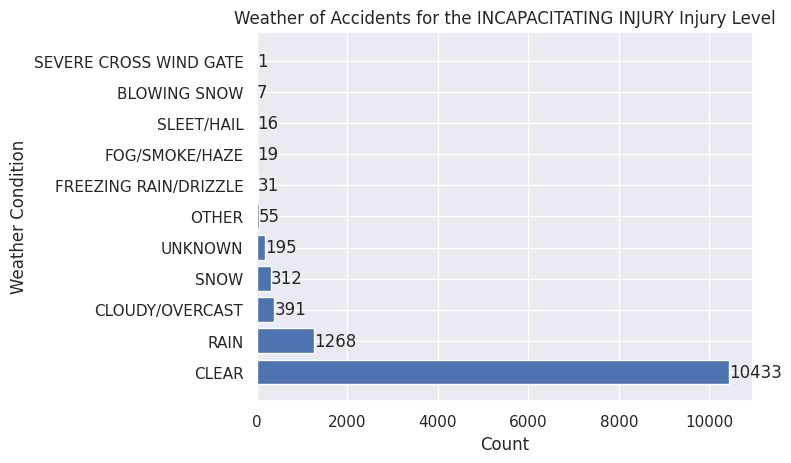

One-Way Frequency Table for the FATAL Injury Level
        Weather Condition  Count  Percentage
0                   CLEAR    669    0.823892
1                    RAIN     78    0.096059
2                    SNOW     23    0.028325
3         CLOUDY/OVERCAST     19    0.023399
4                 UNKNOWN     13    0.016010
5                   OTHER      3    0.003695
6   FREEZING RAIN/DRIZZLE      2    0.002463
7          FOG/SMOKE/HAZE      2    0.002463
8            BLOWING SNOW      2    0.002463
9  SEVERE CROSS WIND GATE      1    0.001232



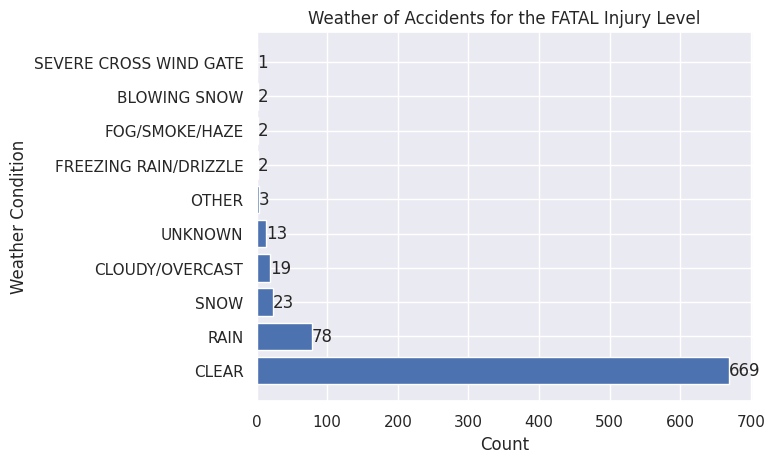

In [ ]:
for severity_level in m_severe_unique:

  injury_severity = m_severe_sub_df[m_severe_sub_df["MOST_SEVERE_INJURY"] == severity_level]

  weather_freqs = injury_severity.WEATHER_CONDITION.value_counts()
  injury_weather_freq = pd.DataFrame({"Weather Condition" : weather_freqs.index, "Count" : weather_freqs.values})

  injury_weather_freq["Percentage"] = injury_weather_freq["Count"] / len(injury_severity)
  print("One-Way Frequency Table for the " + severity_level + " Injury Level")
  print(injury_weather_freq)
  print()

  title = "Weather of Accidents for the " + severity_level + " Injury Level"
  create_bar_plot("horizontal", title,
                  injury_weather_freq["Weather Condition"], injury_weather_freq["Count"], "Count",
                  "Weather Condition")

# Data Cleaning and Preprocessing

In [ ]:
def combine_similar(data):
    data = data.replace('Unknown', 'unknown')
    data = data.replace('Other', 'other')
    data = data.replace('Unknown or other', 'other')
    return data

In [ ]:
data = combine_similar(data)

In [ ]:
data.isna().sum()[data.isna().sum() != 0].sort_values(ascending = False)

WORKERS_PRESENT_I                745383
DOORING_I                        744212
WORK_ZONE_TYPE                   743128
WORK_ZONE_I                      742175
PHOTOS_TAKEN_I                   737007
STATEMENTS_TAKEN_I               730402
NOT_RIGHT_OF_WAY_I               711724
CRASH_DATE_EST_I                 690109
INTERSECTION_RELATED_I           575368
LANE_CNT                         547494
HIT_AND_RUN_I                    513706
REPORT_TYPE                       21222
LONGITUDE                          4908
LATITUDE                           4908
LOCATION                           4908
RD_NO                              4307
MOST_SEVERE_INJURY                 1630
INJURIES_TOTAL                     1619
INJURIES_FATAL                     1619
INJURIES_INCAPACITATING            1619
INJURIES_NON_INCAPACITATING        1619
INJURIES_REPORTED_NOT_EVIDENT      1619
INJURIES_NO_INDICATION             1619
INJURIES_UNKNOWN                   1619
BEAT_OF_OCCURRENCE                    5


In [ ]:
data.T.isna().sum()[data.T.isna().sum() != 0].sort_values(ascending = False)

559550    22
11857     22
135894    22
687320    22
113635    22
          ..
97995      4
593228     4
82294      4
81894      3
287899     3
Length: 746498, dtype: int64

In [ ]:
def more_missing(data):
    data = data.replace('unknown', np.nan)
    data = data.replace('other', np.nan)
    data = data.replace('na', np.nan)
    return data

In [ ]:
data = more_missing(data)

In [ ]:
def prop_imputer(data):
    data_prop = data.copy(deep = True)
    missing_cols = data_prop.isna().sum()[data_prop.isna().sum() != 0].index.tolist()
    for col in missing_cols:
        values_col = data_prop[col].value_counts(normalize = True).index.tolist()
        probabilities_col = data_prop[col].value_counts(normalize = True).values.tolist()
        data_prop[col] = data_prop[col].fillna(pd.Series(np.random.choice(values_col, p = probabilities_col, size = len(data))))
    return data_prop

In [ ]:
data_imp = prop_imputer(data)

In [ ]:
data = data_imp
data.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,012c5bfce715efb2f2b387d6dd86f9c13e9dc1809fb52a...,JG341943,N,07/12/2023 03:05:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,2.0,0.0,15,4,7,41.778542,-87.742065,POINT (-87.742064741348 41.778541938106)
1,01d457f032e23d935a0b8f6b4c88221375180ffd4cd959...,JG338388,Y,07/12/2023 05:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,17,4,7,41.742131,-87.721824,POINT (-87.72182410033 41.742130554062)
2,02249b4747a4bf40b88a8357304a98dfeaef9c38eebbf0...,JG350008,Y,07/12/2023 02:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,...,0.0,0.0,1.0,0.0,14,4,7,41.719844,-87.584790,POINT (-87.584789974824 41.719844228292)
3,03e3b6caad71b78ed9ae325648effa9512bfb2517aed30...,JG338049,Y,07/12/2023 07:05:00 AM,30,TRAFFIC SIGNAL,UNKNOWN,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,7,4,7,41.925105,-87.668291,POINT (-87.668291181568 41.925104953308)
4,0481fc919b38f1572d4ba04b069766102d904a662ff096...,JG338431,Y,07/12/2023 06:30:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,18,4,7,41.975258,-87.751991,POINT (-87.751990557158 41.97525809527)


In [ ]:
data.isna().sum()

CRASH_RECORD_ID                  0
RD_NO                            0
CRASH_DATE_EST_I                 0
CRASH_DATE                       0
POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
LANE_CNT                         0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
REPORT_TYPE                      0
CRASH_TYPE                       0
INTERSECTION_RELATED_I           0
NOT_RIGHT_OF_WAY_I               0
HIT_AND_RUN_I                    0
DAMAGE                           0
DATE_POLICE_NOTIFIED             0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_NO                        0
STREET_DIRECTION                 0
STREET_NAME                      0
BEAT_OF_OCCURRENCE               0
PHOTOS_TAKEN_I      

In [ ]:
# Removing invalid Speed Limit values
data = data[data["POSTED_SPEED_LIMIT"] >= 5]
data = data[data["POSTED_SPEED_LIMIT"] <= 70]
data = data[data["POSTED_SPEED_LIMIT"] % 5 == 0]

# Dropping columns that we probably don't need
cols2drop = ['INJURIES_TOTAL', 'CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'REPORT_TYPE', 'BEAT_OF_OCCURRENCE',
             'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
            'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
             'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'LOCATION']
data = data.drop(cols2drop, axis=1)

In [ ]:
# Reducing out classification to those of injuries
classification_keep = ["NONINCAPACITATING INJURY", "INCAPACITATING INJURY", "FATAL"]

# Subseting using the above list
data = data[data["MOST_SEVERE_INJURY"].isin(classification_keep)]

In [ ]:
numerical_cols = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'LATITUDE', 'LONGITUDE']
ordinal_cols = ['CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']
nominal_cols = [x for x in data.columns if x not in numerical_cols]
nominal_cols = [y for y in nominal_cols if y not in ordinal_cols]

In [ ]:
nominal_cols

['CRASH_DATE',
 'TRAFFIC_CONTROL_DEVICE',
 'DEVICE_CONDITION',
 'WEATHER_CONDITION',
 'LIGHTING_CONDITION',
 'FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE',
 'LANE_CNT',
 'ALIGNMENT',
 'ROADWAY_SURFACE_COND',
 'ROAD_DEFECT',
 'CRASH_TYPE',
 'INTERSECTION_RELATED_I',
 'NOT_RIGHT_OF_WAY_I',
 'HIT_AND_RUN_I',
 'DAMAGE',
 'DATE_POLICE_NOTIFIED',
 'PRIM_CONTRIBUTORY_CAUSE',
 'SEC_CONTRIBUTORY_CAUSE',
 'STREET_NO',
 'STREET_DIRECTION',
 'STREET_NAME',
 'MOST_SEVERE_INJURY']

In [ ]:
# Dict for saving model and encoder
saved_dictionary = {}

def label_encoder(data, cols):
    data_le = data.copy(deep = True)
    for col in cols:
        print(f'Encoding {col}')
        le = LabelEncoder()
        data_le[col] = le.fit_transform(data_le[col])
        saved_dictionary[f'le_{col}'] = le
    return data_le

In [ ]:
Hour_dictionary = {x: x for x in range(24)}
Day_dictionary = {x: x for x in range(1, 8)}
Month_dictionary = {x: x for x in range(1, 13)}
Severity_dictionary = {"NONINCAPACITATING INJURY" : 0, "INCAPACITATING INJURY" : 1, "FATAL" : 2}

In [ ]:
manual_encoder_dictionary = {'CRASH_HOUR': Hour_dictionary,
                       'CRASH_DAY_OF_WEEK' : Day_dictionary,
                       'CRASH_MONTH' : Month_dictionary,
                       'MOST_SEVERE_INJURY' : Severity_dictionary
                      }

In [ ]:
def manual_encoder(data, ordinal_cols, manual_encoder_dictionary):
    data_me = data.copy(deep = True)
    for feature in data.columns:
        if feature in ordinal_cols:
            if feature != 'Accident_severity':
                data_me[feature] = data_me[feature].map(manual_encoder_dictionary[feature])
    return data_me

In [ ]:
data = manual_encoder(data, ordinal_cols, manual_encoder_dictionary)
data = label_encoder(data, nominal_cols)

Encoding CRASH_DATE
Encoding TRAFFIC_CONTROL_DEVICE
Encoding DEVICE_CONDITION
Encoding WEATHER_CONDITION
Encoding LIGHTING_CONDITION
Encoding FIRST_CRASH_TYPE
Encoding TRAFFICWAY_TYPE
Encoding LANE_CNT
Encoding ALIGNMENT
Encoding ROADWAY_SURFACE_COND
Encoding ROAD_DEFECT
Encoding CRASH_TYPE
Encoding INTERSECTION_RELATED_I
Encoding NOT_RIGHT_OF_WAY_I
Encoding HIT_AND_RUN_I
Encoding DAMAGE
Encoding DATE_POLICE_NOTIFIED
Encoding PRIM_CONTRIBUTORY_CAUSE
Encoding SEC_CONTRIBUTORY_CAUSE
Encoding STREET_NO
Encoding STREET_DIRECTION
Encoding STREET_NAME
Encoding MOST_SEVERE_INJURY


In [ ]:
data.head()

,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,...,STREET_NO,STREET_DIRECTION,STREET_NAME,NUM_UNITS,MOST_SEVERE_INJURY,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
33,34790,30,4,3,7,3,8,8,4,3,...,2295,1,333,2,2,6,4,7,41.932261,-87.638388
35,34792,30,4,3,7,3,2,2,4,3,...,5224,2,839,1,1,7,4,7,41.774020,-87.649350
49,34779,30,8,3,7,3,17,6,4,3,...,5008,2,1047,3,2,13,4,7,41.780148,-87.625226
58,34801,30,17,6,11,5,9,17,2,3,...,5083,3,224,2,2,12,4,7,41.945553,-87.786368
73,34778,30,4,3,3,1,2,6,0,3,...,3648,3,995,1,1,1,4,7,41.865886,-87.737486


In [ ]:
def heatmap(data):
    plt.figure(figsize = (36, 27))
    sns.heatmap(data.corr(), annot = True, cmap = plt.cm.CMRmap_r)

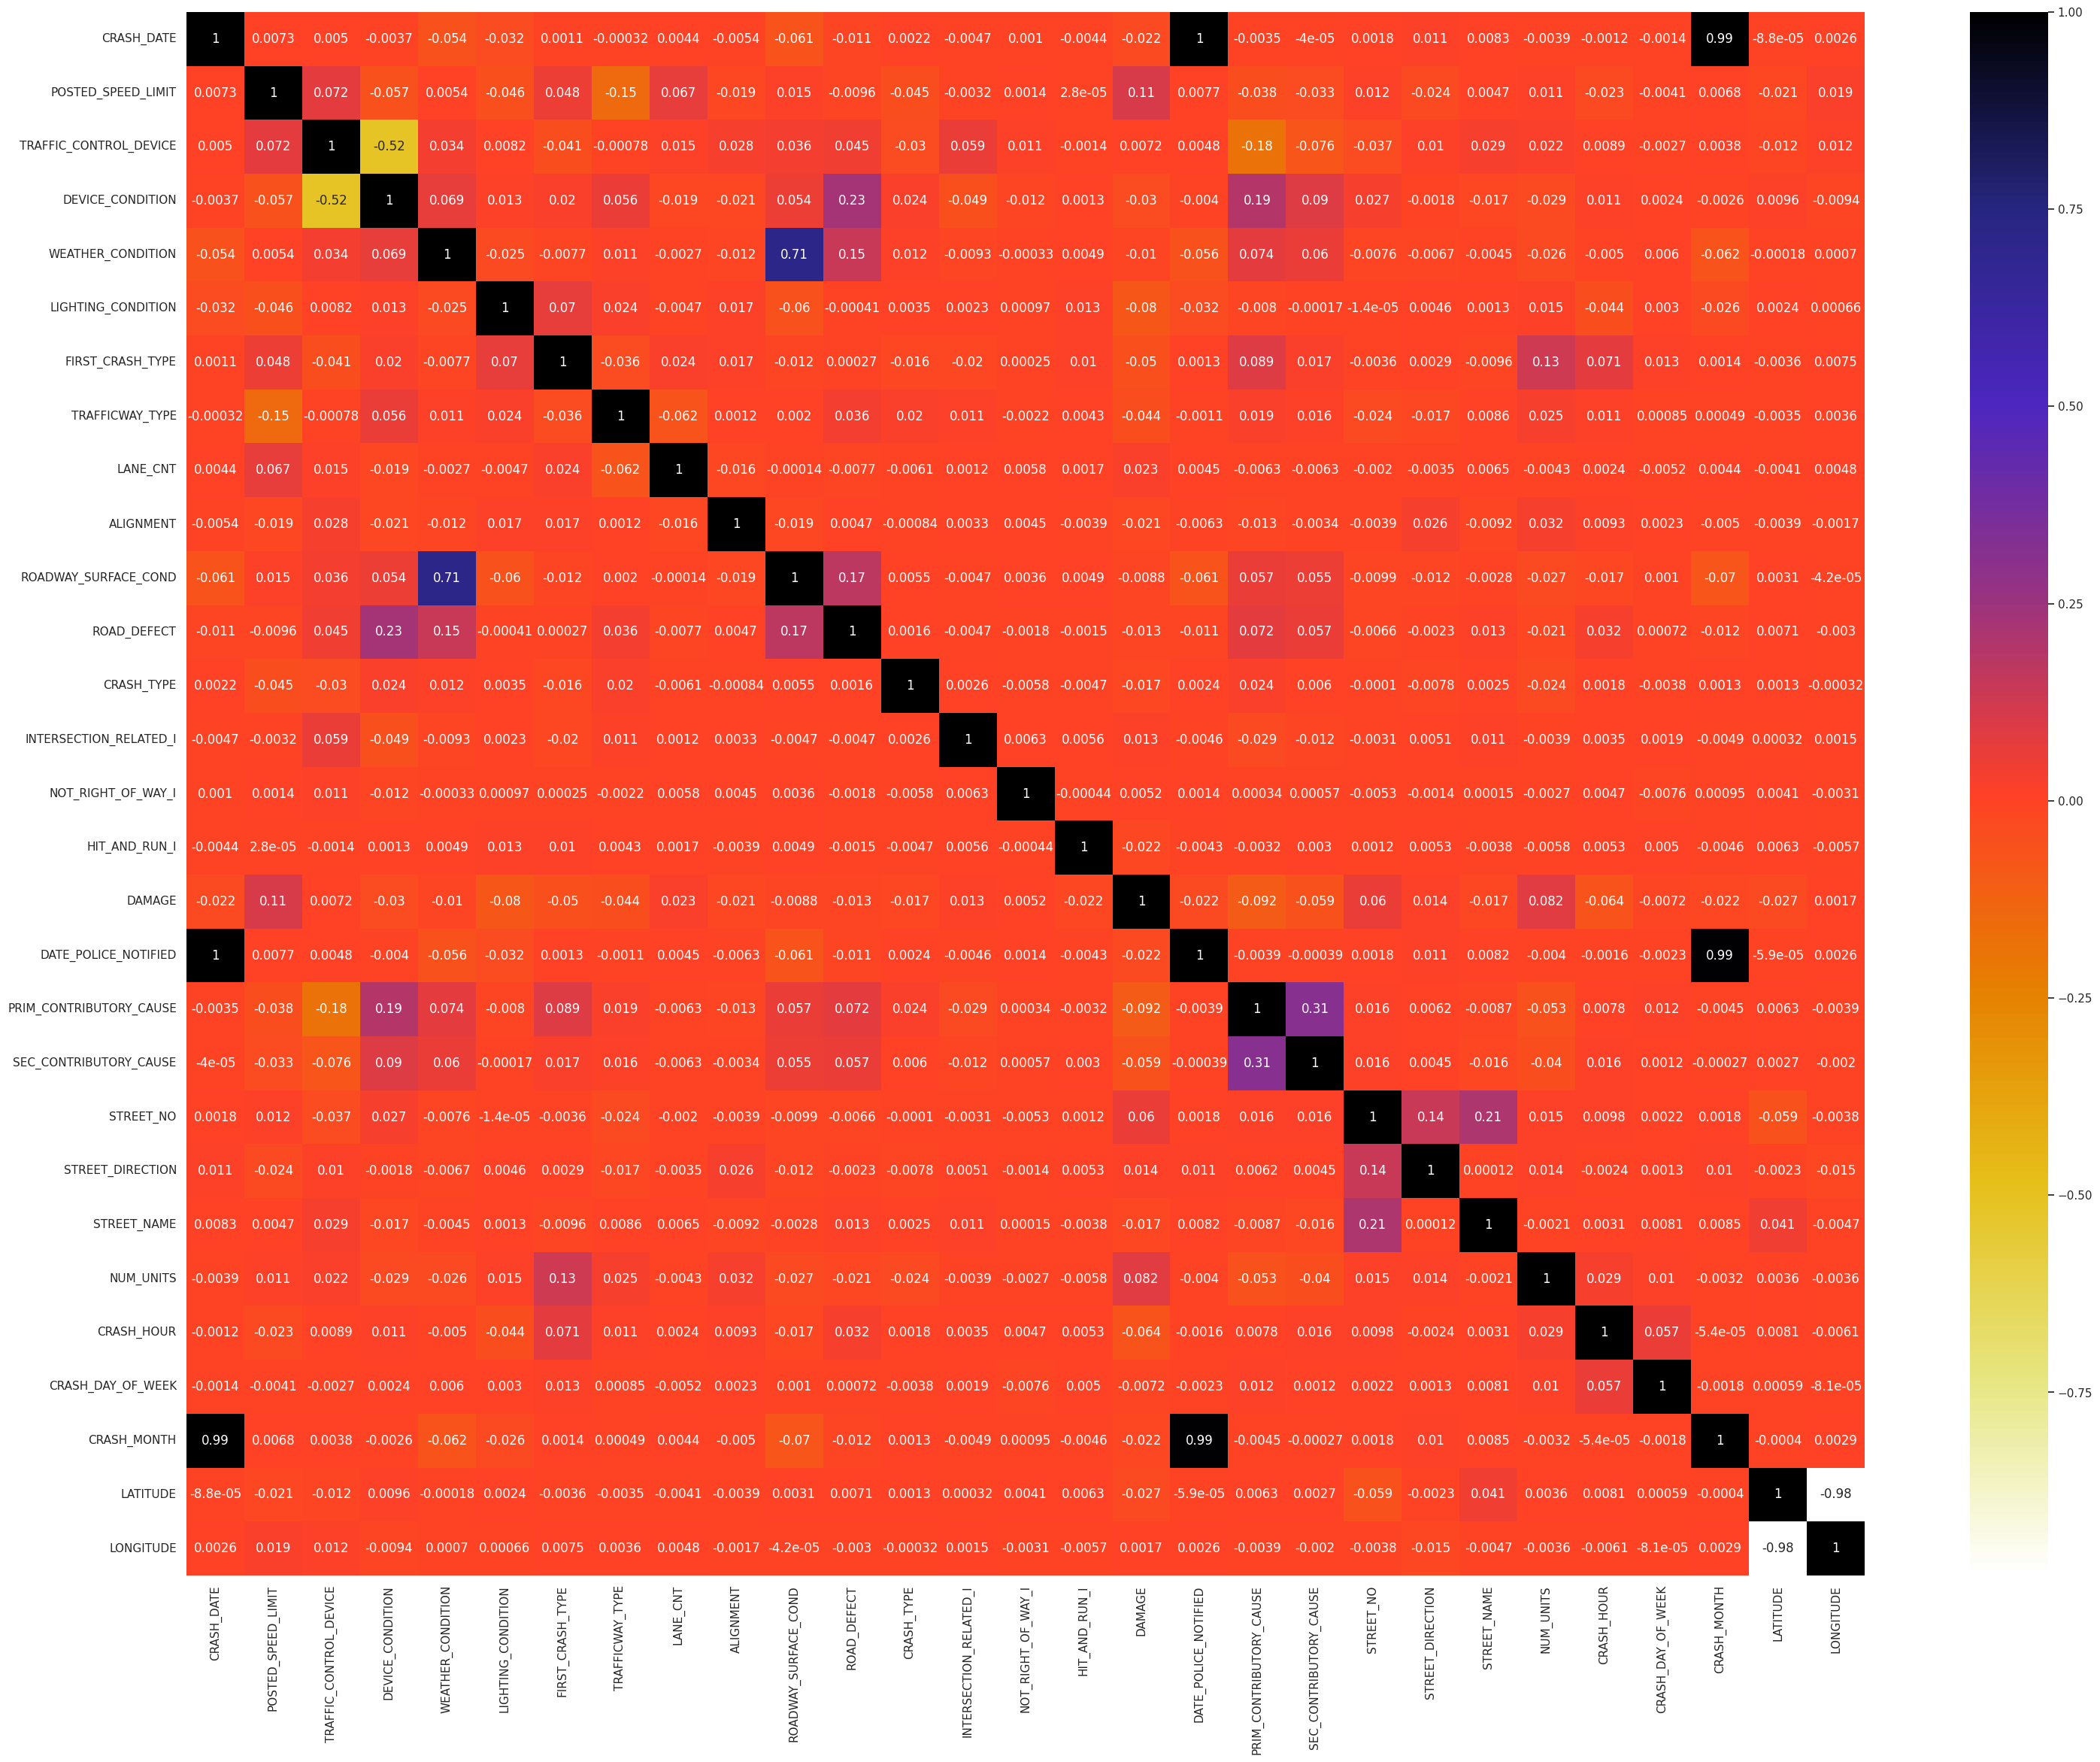

In [ ]:
data_heat = data.drop('MOST_SEVERE_INJURY', axis = 1)
heatmap(data_heat)

In [ ]:
drop_cols = ['DATE_POLICE_NOTIFIED']
data = data.drop(drop_cols, axis = 1)

## Experiments

In [ ]:
def predictor_target_split(data, target):
  y = data[target]
  X = data.drop(target, axis = 1)
  return X, y

In [ ]:
X, y = predictor_target_split(data, 'MOST_SEVERE_INJURY')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
future_comp = y_train

In [ ]:
def smote(X_train, y_train):
  smote = SMOTE(random_state = 42, n_jobs = -1)
  X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
  return X_train_smote, y_train_smote

In [ ]:
def resampler(X_train, y_train, method = smote, countplot = True):
  if method not in [smote]:
    print("Method invalid")
  else:
    X_train_new, y_train_new = method(X_train, y_train)
    return X_train_new, y_train_new

In [ ]:
X_train, y_train = resampler(X_train, y_train, method = smote, countplot = True)

In [ ]:
y_train.value_counts()

2    45737
1    45737
0    45737
Name: MOST_SEVERE_INJURY, dtype: int64

In [ ]:
future_comp.value_counts()

2    45737
1    10159
0      654
Name: MOST_SEVERE_INJURY, dtype: int64

In [ ]:
def spread_pos(data):
  data_positive = data.copy(deep = True)
  for feature in data_positive.columns:
    if np.any(data_positive[feature] < 0) == True:
      data_positive[feature] = data_positive[feature] - data_positive[feature].min()
  return data_positive

def spread_pos_series(data):
  data_positive = data.copy(deep = True)
  if np.any(data_positive < 0) == True:
    data_positive = data_positive - data_positive.min()
  return data_positive

def feature_selection_chi2(X_train, y_train, X_test, k = 'all'):
  if np.any(X_train < 0) == True:
    X_train = spread_pos(X_train)
  if np.any(y_train < 0) == True:
    y_train = spread_pos_series(y_train)
  if np.any(X_test < 0) == True:
    X_test = spread_pos(X_test)

  fs = SelectKBest(score_func = chi2, k = k)
  fs.fit(X_train, y_train)

  cols = fs.get_support(indices = True)

  X_train_fs = X_train.iloc[:, cols]
  X_test_fs = X_test.iloc[:, cols]

  return X_train_fs, X_test_fs, fs

In [ ]:
def feature_selection_mutual_information(X_train, y_train, X_test, k = 'all'):
  fs = SelectKBest(score_func = mutual_info_classif, k = k)
  fs.fit(X_train, y_train)
  cols = fs.get_support(indices = True)
  X_train_fs = X_train.iloc[:, cols]
  X_test_fs = X_test.iloc[:, cols]
  return X_train_fs, X_test_fs, fs

In [ ]:
X_train, X_test, fs = feature_selection_chi2(X_train, y_train, X_test, k = 'all')

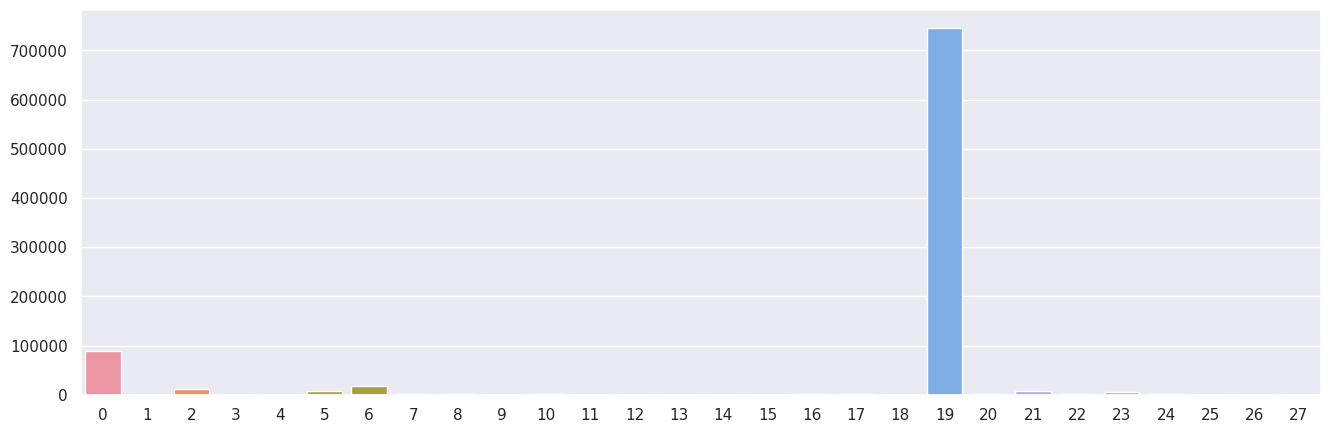

In [ ]:
plt.figure(figsize = (16, 5))
sns.barplot(x = [i for i in range(len(fs.scores_))], y = fs.scores_)
plt.show()

In [ ]:
X_train, X_test, fs = feature_selection_chi2(X_train, y_train, X_test, k = 16)

In [ ]:
def conf_mat(y_pred, y_test):
    class_names = ['Non-Incap', 'Incap', 'Fatal']
    tick_marks_y = [0.5, 1.5, 2.5]
    tick_marks_x = [0.5, 1.5, 2.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(3), range(3))
    plt.figure(figsize = (6, 4.75))
    sns.set(font_scale = 1.4) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": 16}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [ ]:
f1_dict = {}

Weighted F1-score on the test set: 0.6630093512367116


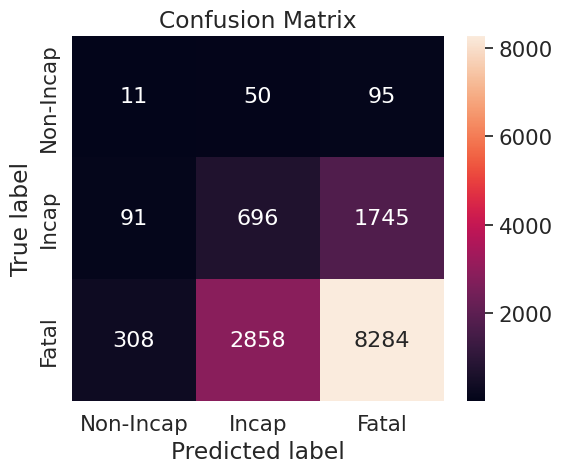

In [ ]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Decision Tree'] = score
conf_mat(y_pred, y_test)

Weighted F1-score on the test set: 0.7219134192185502


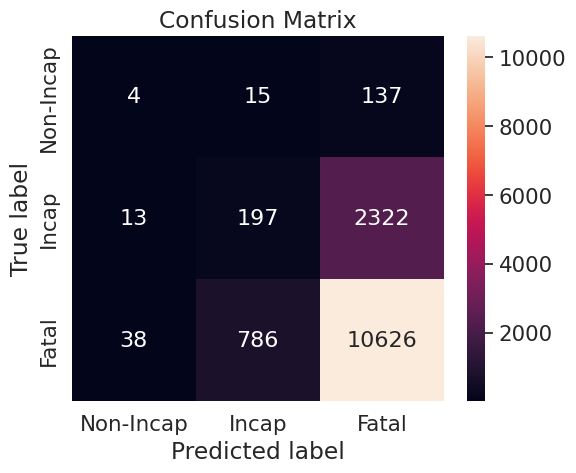

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Random Forest'] = score
conf_mat(y_pred, y_test)

weighted F1-score on the test set: 0.7219134192185502


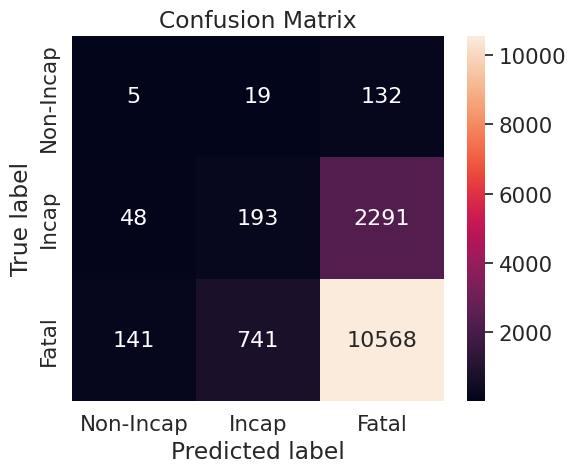

In [ ]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("weighted F1-score on the test set: {}".format(score))
f1_dict['XGBoost'] = score
conf_mat(y_pred_xgb, y_test)

Weighted F1-score on the test set: 0.7194926010186186


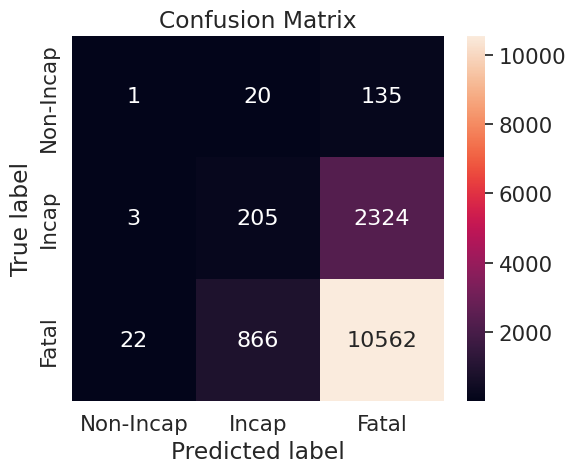

In [ ]:
extree = ExtraTreesClassifier(random_state = 42)
extree.fit(X_train, y_train)
y_pred = extree.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['ExtraTrees'] = score
conf_mat(y_pred, y_test)

In [ ]:
f1_df = pd.DataFrame(f1_dict.items(), columns = ['Classifier', 'F1-score'])
f1_df.sort_values(by = ['F1-score'], ascending = False)

,Classifier,F1-score
1,Random Forest,0.721913
2,XGBoost,0.721913
3,ExtraTrees,0.719493
0,Decision Tree,0.663009


In [ ]:
# W/ K-Fold cross validation to find optimal parameters for a couple of the algorithms
f1_dict_ht = {}

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best weighted F1-score: 0.8958648667987916
 
Weighted F1-score on the test set: 0.7323322481584774


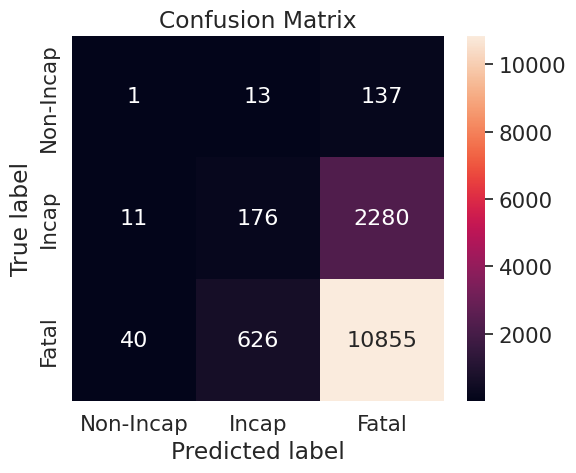

In [ ]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42).split(X = X_train, y = y_train)
rf = RandomForestClassifier()
params_rf = {'n_estimators': [100, 200],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None],
          'max_features': ['auto', 'sqrt', 'log2'],
          'class_weight': ['balanced', None]
          }
gsearch_rf = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_rf_fit = gsearch_rf.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_rf.best_params_))
print("Best weighted F1-score: {}".format(gsearch_rf.best_score_))
print(" ")

rf_best = gsearch_rf.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)
score = f1_score(y_test, y_pred_rf, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict_ht['Random Forest'] = score
conf_mat(y_pred_rf, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 1.0}
Best weighted F1-score: 0.7928469196313155
 
Weighted F1-score on the test set: 0.7194140123773678


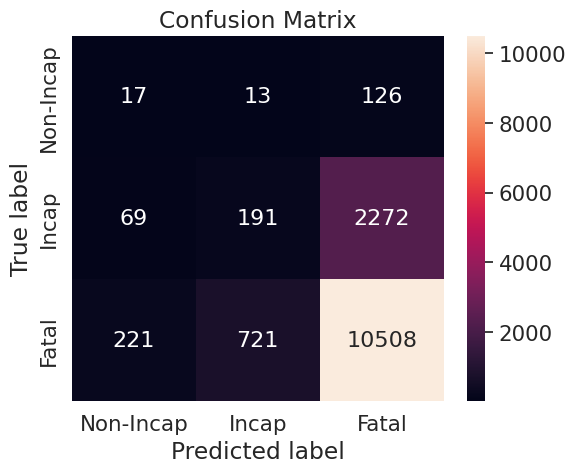

In [ ]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42).split(X = X_train, y = y_train)
xgb = XGBClassifier()
params_xgb = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 2, 5],
              'subsample': [0.6, 1.0],
              'colsample_bytree': [0.6],
              'max_depth': [4, 5],
              }
gsearch_xgb = GridSearchCV(estimator = xgb, param_grid = params_xgb, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_xgb_fit = gsearch_xgb.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_xgb.best_params_))
print("Best weighted F1-score: {}".format(gsearch_xgb.best_score_))
print(" ")

xgb_best = gsearch_xgb.best_estimator_
xgb_best.fit(X_train, y_train)
y_pred_xgb = xgb_best.predict(X_test)
score = f1_score(y_test, y_pred_xgb, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict_ht['ExtraTrees'] = score
conf_mat(y_pred_xgb, y_test)

In [ ]:
f1_df_ht = pd.DataFrame(f1_dict_ht.items(), columns = ['Classifier', 'F1-score'])
f1_df_ht.sort_values(by = ['F1-score'], ascending = False)

,Classifier,F1-score
0,Random Forest,0.724164
1,ExtraTrees,0.719414
